## Summary

MRIs are one of the essential tools used to diagnose dementia. Enhancing and reading MRIs can be a time-intensive process for technicians and doctors, providing an opportunity for machine learning to create efficiencies. This notebook will cover my process for evaluating the power of Convolutional Neural Networks (CNNs) in identifying characteristics of dementia from RAW (unprocessed) and preprocessed MRI images. The RAW MRI images come from the OASIS-2 study (http://www.oasis-brains.org/) which consists of multiple MRI sessions for 150 subjects, roughly evenly balanced between cognitively normal and demented individuals. Each MRI came in the nifti file type and included 128 slices of the brain condensed into one 3D image. 2D png images of the center slices were extracted and used in models to classify the brain as either belonging to a cognitively normal or demented subject.
Multiple different models were trialed, including custom CNNs and pretrained models such as VGG16 and ResNet50. 
Performance was measured in terms of accuracy and binary cross-entropy loss.

My initial hypothesis was that this would be a difficult task since .

Using CNNs to identify dementia patients has been well documented in the scientific community, but the scans used often have additional preprocessing techniques like bias field correction, brain extraction and noise reduction as well as segmentation of the grey matter, white matter and CSF performed. Due to a lack of time and expertise, these methods could not be applied in this study, but I still would like to see what predictive power could be extracted from the RAW MRIs themselves. Ultimately, the models proved to be unsuccessful in identifying dementia as the best model recorded test accuracy of only 57% using the middle slice of the brain. 

In [25]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import nibabel as nib
import random
import shutil
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import seaborn as sns
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, BatchNormalization, Flatten, Conv2D, MaxPooling2D 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
import warnings
warnings.filterwarnings('ignore')

## EDA/Data Visualization

In [7]:
#load MRI image using nibabel, an python package designed for reading nifti file types
nifti_file = nib.load('/Users/mike/Brain_MRI/Demented_MRI/OAS2_0002_MR1/RAW/mpr-1.nifti.img')

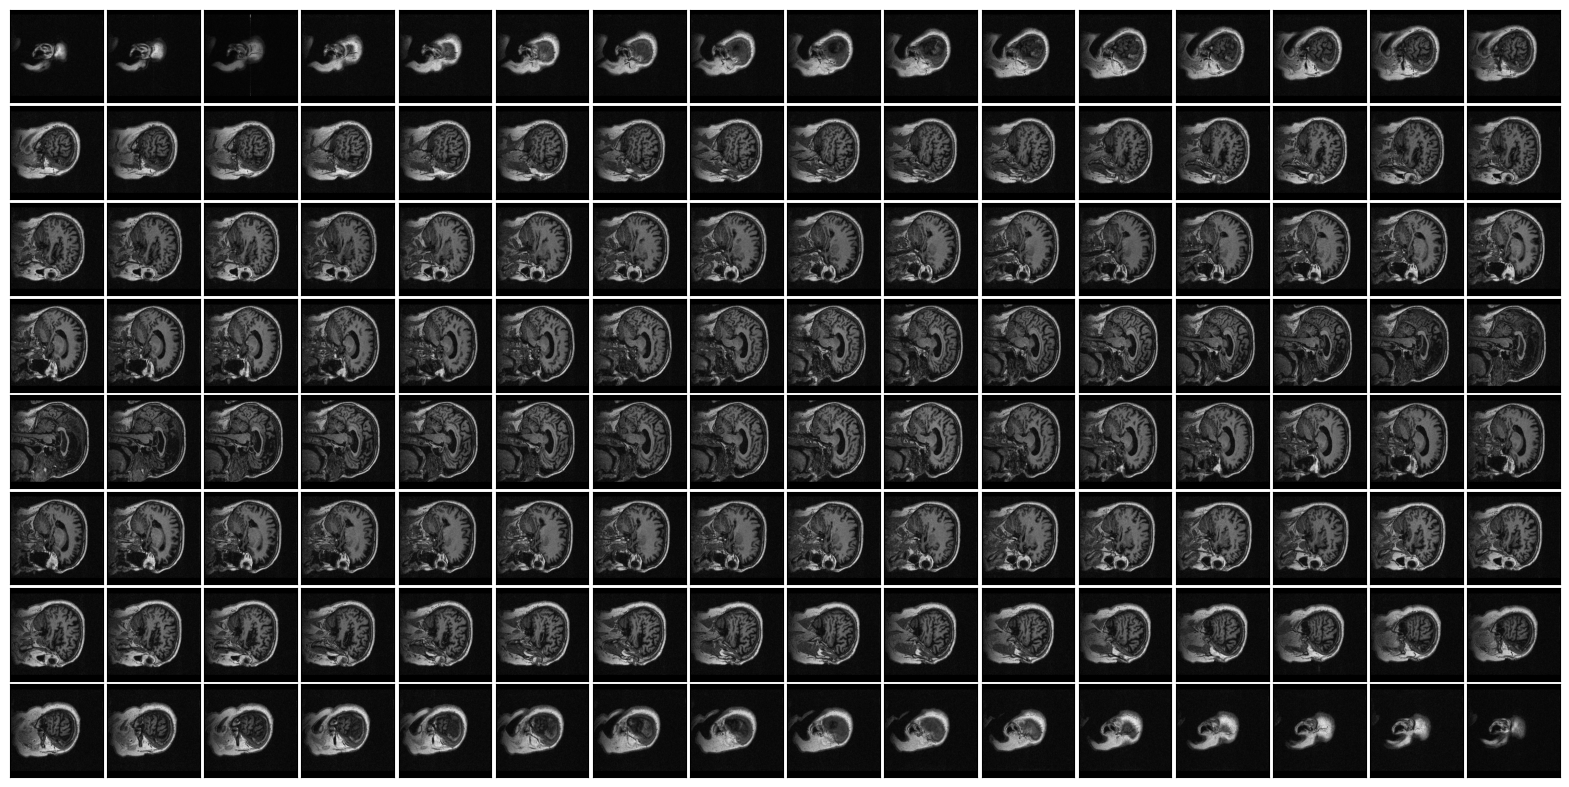

In [9]:
#get the underlying pixel values in array format
img_data = nifti_file.get_fdata()

# Create a grid to house the images 
fig, axes = plt.subplots(nrows = 8, ncols = 16, figsize=(20, 10))

# Flatten the axes array for indexing
axes = axes.ravel()

# Iterate over the 128 slices of the brain and show each one 
for i in range(img_data.shape[2]):
    img_slice = img_data[:, :, i, 0]
    axes[i].imshow(img_slice, cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.01)

# Show the plot
plt.show()

The images above show that each of the 128 slices of the MRI file shows a different depth of the brain. One issue we will encounter in using 2D images is identifying which slice of the brain dementia presents itself most clearly. My research indicated that precuneus and hippocampus atrophy are among the best biological indicators of Alzheimer's Disease (the leading cause of dementia). Both these ares are located towards the center of the brain, so for my 2D analysis, I chose to run models using the center slice of the brain.

## Train-Test-Validation Split

The original study sample included 150 subjects: 72 cognitively normal subjects, 64 characterized as demented and  14 who began as cognitively normal and converted to demented over the course of the study. The converters were excluded since the exact scan the conversion was observed could not be determined. Of the reamining patients' scans, 10% were allocated to the validation set and 10% were allocated to the test set. The remaining subjects were used for training.

In [10]:
df = pd.read_excel('/Users/mike/Brain_MRI/oasis_longitudinal_demographics.xlsx')
df = df.loc[df['Group'] != 'Converted']

#establish demented and non-demented patient groups
demented_subjects = df['Subject ID'].loc[df['Group'] == 'Demented'].drop_duplicates('first').tolist()
nondemented_subjects = df['Subject ID'].loc[df['Group'] == 'Nondemented'].drop_duplicates('first').tolist()

#create reference lists for sorting dementia patients
test_dementia = demented_subjects[0:6]
val_dementia = demented_subjects[6:12]
train_dementia = demented_subjects[12:64]

#create reference lists for sorting non=dementia patients
test_nondementia = nondemented_subjects[0:7]
val_nondementia = nondemented_subjects[7:14]
train_nondementia = nondemented_subjects[14:72]

The code below is left commented out, but was used to sort the images into train-test-validation directories that could be fed into ImageDataGenerator for easy labeling and modeling.

In [ ]:
#this block of code was used on my local system to extract the middle slice of the Dementia MRI scans and organize into train-test-validation folders

# counter = 0

# for folder in os.listdir('/Users/mike/Brain_MRI/Demented_MRI'):
#     if folder != '.DS_Store':
#         for images in os.listdir('/Users/mike/Brain_MRI/Demented_MRI/{}/RAW'.format(folder)):
#             if images.endswith('.nifti.img'):
#                 # get the subject name from the folder
#                 subject_name = folder.split('_MR')[0]
                
#                 # determine which list the subject belongs to
#                 if subject_name in train_dementia:
#                     output_folder = '/Users/mike/Brain_MRI/New Train/Dementia'
#                 elif subject_name in val_dementia:
#                     output_folder = '/Users/mike/Brain_MRI/New Validation/Dementia'
#                 elif subject_name in test_dementia:
#                     output_folder = '/Users/mike/Brain_MRI/New Test/Dementia'
#                 else:
#                     # skip the iteration if the subject is not in any list
#                     continue
                
#                 # rest of the code for extracting the middle slice and saving the PNG
#                 nifti_images = nib.load('/Users/mike/Brain_MRI/Demented_MRI/{}/RAW/{}'.format(folder, images))
#                 nifti_array = nifti_images.get_fdata()
#                 middle_slice = 64
#                 layer = nifti_array[:, :, middle_slice, 0]
#                 layer = (layer - layer.min()) / (layer.max() - layer.min())
#                 image = Image.fromarray((layer * 255).astype(np.uint8))
                
#                 file_path = os.path.join(output_folder, f'layer_{middle_slice:03d}{counter}.png')
#                 image.save(file_path)
#                 counter += 1

In [ ]:
#this block of code was used on my local system to extract the middle slice of the Nondementia MRI scans and organize into train-test-validation folders

# counter = 0

# for folder in os.listdir('/Users/mike/Brain_MRI/Nondemented_MRI'):
#     if folder != '.DS_Store':
#         for images in os.listdir('/Users/mike/Brain_MRI/Nondemented_MRI/{}/RAW'.format(folder)):
#             if images.endswith('.nifti.img'):
#                 # get the subject name from the folder
#                 subject_name = folder.split('_MR')[0]
                
#                 # determine which list the subject belongs to
#                 if subject_name in train_nondementia:
#                     output_folder = '/Users/mike/Brain_MRI/New Train/Nondementia'
#                 elif subject_name in val_nondementia:
#                     output_folder = '/Users/mike/Brain_MRI/New Validation/Nondementia'
#                 elif subject_name in test_nondementia:
#                     output_folder = '/Users/mike/Brain_MRI/New Test/Nondementia'
#                 else:
#                     # skip the iteration if the subject is not in any list
#                     continue
                
#                 # rest of the code for extracting the middle slice and saving the PNG
#                 nifti_images = nib.load('/Users/mike/Brain_MRI/Nondemented_MRI/{}/RAW/{}'.format(folder, images))
#                 nifti_array = nifti_images.get_fdata()
#                 middle_slice = 64
#                 layer = nifti_array[:, :, middle_slice, 0]
#                 layer = (layer - layer.min()) / (layer.max() - layer.min())
#                 image = Image.fromarray((layer * 255).astype(np.uint8))
                
#                 file_path = os.path.join(output_folder, f'layer_{middle_slice:03d}{counter}.png')
#                 image.save(file_path)
#                 counter += 1

In [11]:
#identify paths for train, validation and test sets
train_path = '/Users/mike/Brain_MRI/New Train'
val_path = '/Users/mike/Brain_MRI/New Validation'
test_path = '/Users/mike/Brain_MRI/New Test'

#generate image arrays and labels for train, validation and test using ImageDataGenerator

#train includes data augmentation with horizontal flip and random rotation 
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True, rotation_range = 20)
train_generator = train_datagen.flow_from_directory(train_path, target_size =(256,256), batch_size = 32,
                                                   class_mode = 'binary', color_mode='grayscale')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path, target_size =(256,256), batch_size = 32,
                                                  class_mode= 'binary', shuffle = False, color_mode='grayscale')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = train_datagen.flow_from_directory(val_path, target_size =(256,256), batch_size = 32,
                                                  class_mode= 'binary', shuffle = False, color_mode='grayscale')

Found 990 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Found 123 images belonging to 2 classes.


In [13]:
#confirm the key for generator class labels 
class_indices = train_generator.class_indices
class_indices

{'Dementia': 0, 'Nondementia': 1}

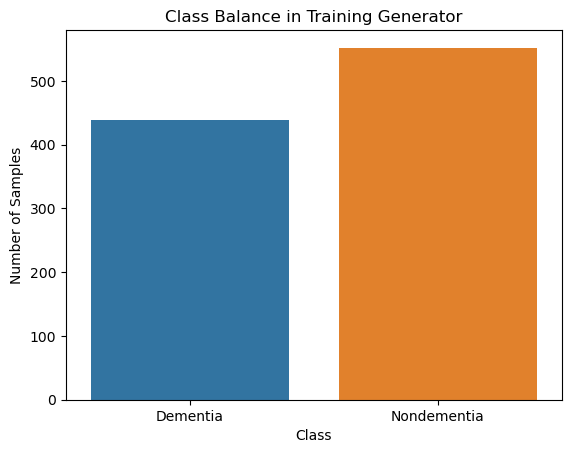

In [18]:
# Get the class indices from the generator
class_indices = train_generator.class_indices

# Get the number of samples for each class
num_samples = []
for key in class_indices.keys():
    num_samples.append(len(train_generator.labels[train_generator.labels==class_indices[key]]))

# Create a bar chart to visualize the class balance
sns.barplot(x=list(class_indices.keys()), y=num_samples)
plt.title('Class Balance in Training Generator')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


There is a slight class imbalance skewed towards the nondementia class. The difference is small, so I will leave balance as is for now

## RAW Baseline Model

For the baseline model, I will use a simple CNN with two convolutional and one dense layer.

In [32]:
#instantiate a model
baseline_model = Sequential()


# add the input layer  
baseline_model.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(256, 256, 1)))

baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
baseline_model.add(Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu'))

baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers. output for binary classification
baseline_model.add(Flatten())
baseline_model.add(Dense(512, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
baseline_model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
history_base = baseline_model.fit(train_generator, validation_data = val_generator, epochs = 10, verbose = 1, callbacks = [early_stopping])

Epoch 1/10


2023-04-16 19:11:04.811528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.7306 - accuracy: 0.5535

2023-04-16 19:11:08.987041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 5s 132ms/step - loss: 0.7306 - accuracy: 0.5535 - val_loss: 0.6727 - val_accuracy: 0.5935
Epoch 2/10
31/31 [==============================] - 3s 100ms/step - loss: 0.6631 - accuracy: 0.5899 - val_loss: 0.6923 - val_accuracy: 0.5041
Epoch 3/10
31/31 [==============================] - 3s 108ms/step - loss: 0.6103 - accuracy: 0.6545 - val_loss: 0.6233 - val_accuracy: 0.6829
Epoch 4/10
31/31 [==============================] - 3s 101ms/step - loss: 0.5387 - accuracy: 0.7172 - val_loss: 0.6603 - val_accuracy: 0.6667
Epoch 5/10
31/31 [==============================] - 3s 99ms/step - loss: 0.4820 - accuracy: 0.7707 - val_loss: 0.7624 - val_accuracy: 0.5366
Epoch 6/10
31/31 [==============================] - 3s 99ms/step - loss: 0.4591 - accuracy: 0.7828 - val_loss: 0.6452 - val_accuracy: 0.6911
Epoch 7/10
31/31 [==============================] - 3s 106ms/step - loss: 0.4371 - accuracy: 0.8051 - val_loss: 0.6226 - val_accuracy: 0.6748
Epoch 8/10
31/31 [=

In [34]:
test_loss, test_accuracy = baseline_model.evaluate(test_generator, verbose =1)
print('Test loss: {} Test accuracy: {}'.format(test_loss, test_accuracy))

4/4 [==============================] - 0s 44ms/step - loss: 1.7691 - accuracy: 0.4793
Test loss: 1.769081711769104 Test accuracy: 0.4793388843536377


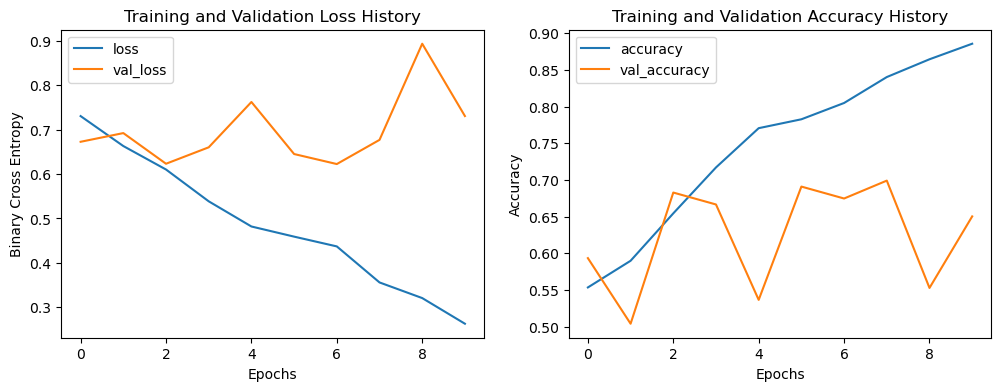

In [35]:
base_history = pd.DataFrame(history_base.history)
base_history.index.name = 'Epochs'

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

col_list1 = ['loss', 'val_loss']
ax[0].plot(base_history.index, base_history[col_list1])
ax[0].set_ylabel('Binary Cross Entropy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Training and Validation Loss History')
ax[0].legend(col_list1)

col_list2 = ['accuracy', 'val_accuracy']
ax[1].plot(base_history.index, base_history[col_list2])
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Training and Validation Accuracy History')
ax[1].legend(col_list2)

plt.show()

Baseline test accuracy and loss are 47% and 1.76 respectively. The model performs slightly worse than random chance at identifying dementia from the RAW MRIs. Based on the visualizations of the traning vs validation performance, we can see that the model is clearly overfitting, but there seems to be a consistent random trend in the validation. The test scores are also very different from the validation set which may be a sign the model is optimizing towards weights and not necessarily picking up on the patterns in the data.


In [39]:
#save model weights for future use
baseline_model.save('/Users/mike/Capstone Project/Saved Model Weights/RAW_baseline_model')

## Model 1 - RAW

In this model iteration, I will add more convolutional layers as well as dropout to my dense layer. The goal is to increase the level of detail the model captures, while trying to reduce some of the overfitting.

In [37]:
model_1 = Sequential()


# add the input layer  
model_1.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(256, 256, 1)))
# max pool in 2x2 window
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
model_1.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu'))

# max pool in 2x2 window
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
model_1.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu'))

# max pool in 2x2 window
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
model_1.add(Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu'))

# max pool in 2x2 window
model_1.add(MaxPooling2D(pool_size=(2, 2)))


# connect all nodes with dense layers. output for binary classification
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(.5))
model_1.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_1.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
history_model_1 = model_1.fit(train_generator, validation_data = val_generator, epochs = 10, verbose = 1, callbacks = [early_stopping])

Epoch 1/10


2023-04-16 19:26:42.350119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.5626

2023-04-16 19:26:47.720297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 6s 145ms/step - loss: 0.6890 - accuracy: 0.5626 - val_loss: 0.6839 - val_accuracy: 0.5854
Epoch 2/10
31/31 [==============================] - 4s 118ms/step - loss: 0.6830 - accuracy: 0.5354 - val_loss: 0.6659 - val_accuracy: 0.5854
Epoch 3/10
31/31 [==============================] - 4s 115ms/step - loss: 0.6656 - accuracy: 0.6051 - val_loss: 0.6578 - val_accuracy: 0.5772
Epoch 4/10
31/31 [==============================] - 4s 119ms/step - loss: 0.6436 - accuracy: 0.6465 - val_loss: 0.6056 - val_accuracy: 0.6992
Epoch 5/10
31/31 [==============================] - 4s 133ms/step - loss: 0.6203 - accuracy: 0.6626 - val_loss: 0.6449 - val_accuracy: 0.6179
Epoch 6/10
31/31 [==============================] - 4s 126ms/step - loss: 0.6155 - accuracy: 0.6798 - val_loss: 0.6440 - val_accuracy: 0.6179
Epoch 7/10
31/31 [==============================] - 4s 117ms/step - loss: 0.5987 - accuracy: 0.6737 - val_loss: 0.7087 - val_accuracy: 0.6098
Epoch 8/10
31/31 

In [38]:
test_loss, test_accuracy = model_1.evaluate(test_generator, verbose =1)
print('Test loss: {} Test accuracy: {}'.format(test_loss, test_accuracy))

4/4 [==============================] - 1s 117ms/step - loss: 1.0059 - accuracy: 0.4959
Test loss: 1.0058866739273071 Test accuracy: 0.4958677887916565


Test performance improved slightly, but is still less accurate than random chance. The dropout seems to have improved the gap in scores between the training and validation set, but test scores remain significantly lower. My inital concern is that there is an issue with the test set, but in reveiwing the scan files and the patient demogrpahic information, the test patients do not seem to be outliers in any way.

In [40]:
#save model weights for future use
model_1.save('/Users/mike/Capstone Project/Saved Model Weights/RAW_model_1')

## Model 2 - RAW